# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_org = pd.read_csv('./datasets/organizations.csv')
df_methods = pd.read_csv('./datasets/payment_methods.csv')
df_payments = pd.read_csv('./datasets/payments.csv')

In [3]:
for x in [df_org, df_methods, df_payments]:
    display(x.head())

,customer_id,first_payment_date,channel
0,5568,2020-03-03,2
1,6763,2020-03-05,2
2,6816,2020-06-04,2
3,22350,2020-03-24,2
4,40800,2020-01-27,2


,payment_method_id,fixed_rate,variable_rate
0,3,0.29,0.000
1,11,0.25,0.018
2,17,0.39,0.000
3,19,0.25,0.000


,customer_id,payment_month,payment_method_id,total_transactions,total_volume
0,3120659,2020-01-01,3,241,2543.28
1,3627499,2020-01-01,3,430,27037.00
2,3611429,2020-01-01,3,117,6100.00
3,3772639,2020-01-01,3,27,720.56
4,3789659,2020-01-01,3,15,440.35


# Exploration

In [4]:
def column_checks(df):
    report = {}
    
    for column in df.columns:
        data = df[column]
        # Setting default column info dictionary
        col_info = {
            'data_type': data.dtype,
            'num_null_values': data.isnull().sum(),
            'num_unique_values': data.nunique(),
            'unique_ratio': data.nunique() / len(data),
            'has_duplicates': not data.is_unique,
            'num_duplicates': len(data) - data.nunique(),
            'most_frequent_value': data.mode()[0] if not data.mode().empty else None,
            'is_numeric': pd.api.types.is_numeric_dtype(data),
            'is_date': False,
            'has_invalid_dates': None
        }
        
        # Check if column potentially contains dates
        if data.dtype == 'object' or pd.api.types.is_string_dtype(data):
            try:
                date_series = pd.to_datetime(data, errors='coerce')
                if pd.api.types.is_datetime64_any_dtype(date_series):
                    col_info['is_date'] = True
                    col_info['has_invalid_dates'] = date_series.isna().sum() > data.isnull().sum()
                    col_info['is_numeric'] = False
            except Exception as e:
                col_info['is_date'] = False
                col_info['has_invalid_dates'] = None

        # Summary stats for numeric columns
        if col_info['is_numeric']:
            col_info['mean'] = data.mean()
            col_info['min'] = data.min()
            col_info['max'] = data.max()
            col_info['std'] = data.std()
        
        report[column] = col_info
    
    report_df = pd.DataFrame(report)
    return report_df


## Companies

In [5]:
column_checks(df_org)

,customer_id,first_payment_date,channel
data_type,int64,object,int64
num_null_values,0,0,0
num_unique_values,10098,181,2
unique_ratio,1.0,0.017924,0.000198
has_duplicates,False,True,True
num_duplicates,0,9917,10096
most_frequent_value,5568,2020-01-02,2
is_numeric,True,False,True
is_date,False,True,False
has_invalid_dates,None,False,None


In [6]:
df_org['first_payment_date'] = pd.to_datetime(df_org['first_payment_date'])

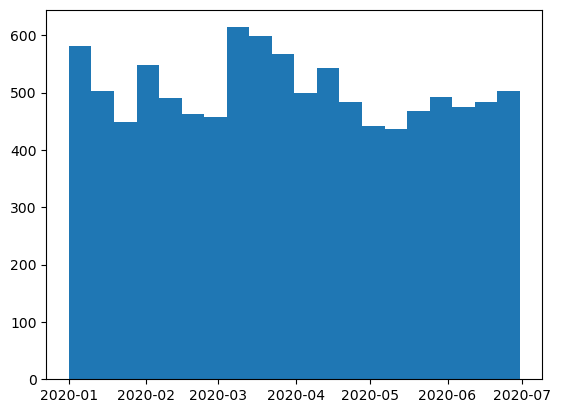

In [7]:
plt.hist(df_org['first_payment_date'], bins=20);

## Payments

In [8]:
column_checks(df_payments)

,customer_id,payment_month,payment_method_id,total_transactions,total_volume
data_type,int64,object,int64,int64,float64
num_null_values,0,0,0,0,0
num_unique_values,9871,6,4,667,18495
unique_ratio,0.320674,0.000195,0.00013,0.021669,0.600838
has_duplicates,True,True,True,True,True
num_duplicates,20911,30776,30778,30115,12287
most_frequent_value,3880359,2020-06-01,3,1,1.0
is_numeric,True,False,True,True,True
is_date,False,True,False,False,False
has_invalid_dates,None,False,None,None,None


In [9]:
pd.api.types.is_string_dtype(df_payments.payment_month)

True

In [10]:
df_payments.payment_month = pd.to_datetime(df_payments.payment_month)

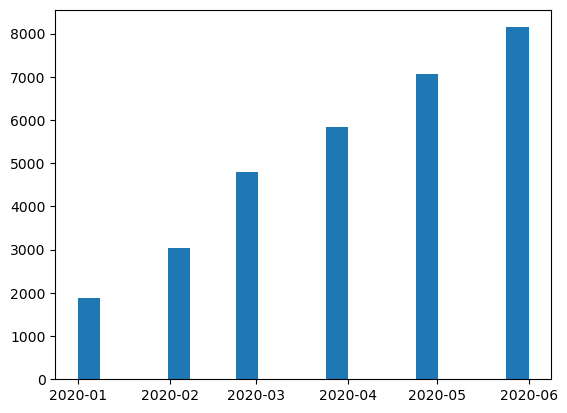

In [11]:
plt.hist(df_payments['payment_month'], bins=20);

In [12]:
# Checking if there are payments earlier than the first payment date
(
    pd.merge(df_payments, df_org, on='customer_id')
    .assign(
        first_payment_month= lambda x: x['first_payment_date'].dt.to_period('M').dt.to_timestamp()
    )
    .where(lambda x: x['payment_month'] < x['first_payment_month'])
    .dropna()
    .empty
)

True

In [13]:
# Checking if there are payments without customer data
_df = pd.merge(df_payments, df_org, on='customer_id', how='left')

In [14]:
_df[_df['customer_id'].isna()].empty

True

In [15]:
# What payment methods are available?
_df.payment_method_id.unique()

array([ 3, 11, 17, 19], dtype=int64)

In [16]:
# Checking if there are customers without payments
df_payments.customer_id.nunique(), df_org.customer_id.nunique()

(9871, 10098)

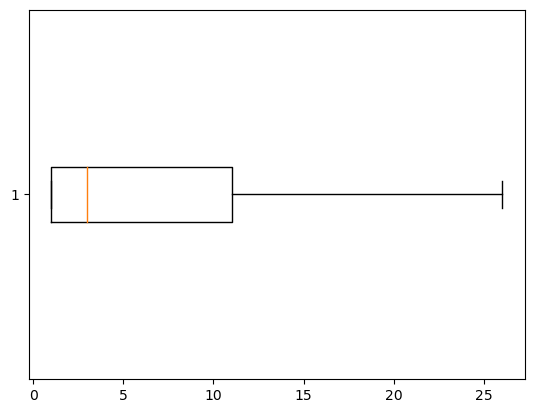

In [17]:
# How many transactions per customer occur monthly?
plt.boxplot(df_payments['total_transactions'], vert=False, showfliers=False);

In [18]:
# Checking the distribution of values for total_volume
df_payments.total_volume.describe()

count    3.078200e+04
mean     2.926663e+03
std      3.726283e+04
min      1.000000e-02
25%      6.000000e+01
50%      2.444350e+02
75%      1.036648e+03
max      2.550223e+06
Name: total_volume, dtype: float64

In [19]:
# Are there any negative values?
df_payments.total_volume[df_payments.total_volume < 0].count()

0

In [20]:
# What about extremely low values?
df_payments.total_volume[df_payments.total_volume < 1].count()

485

# Transactions df compose

In [89]:
df_org = pd.read_csv('./datasets/organizations.csv', parse_dates=['first_payment_date'])
df_methods = pd.read_csv('./datasets/payment_methods.csv')
df_payments = pd.read_csv('./datasets/payments.csv', parse_dates=['payment_month'])

dates = (df_payments.payment_month.min(), df_payments.payment_month.max())

df = (
    pd.merge(
        df_org, 
        (
            pd.date_range(start=dates[0], end=dates[1], freq='MS')
            .to_frame(index=False, name='payment_month')
        ), 
        how='cross'
    )
    .assign(
        first_payment_month= lambda x: x['first_payment_date'].dt.to_period('M').dt.to_timestamp()
    )
    .where(lambda x: x['payment_month'] >= x['first_payment_month'])
    .dropna()
    .merge(df_payments, on=['customer_id', 'payment_month'], how='left')
)

# Adding additional information for payment methods
df = (
    df
    .merge(df_methods, on='payment_method_id', how='left')
    .assign(
        fixed_rate_comission=lambda x: x['total_transactions'] * x['fixed_rate'],
        variable_rate_comission=lambda x: x['total_volume'] * x['variable_rate'],
        total_comission=lambda x: x['fixed_rate_comission'] + x['variable_rate_comission']
    )
)

n_a_fill_cols = [
    x for x in df.columns if x not in ['first_payment_date', 'payment_month', 'payment_method_id', 'customer_id']
]

df[n_a_fill_cols] = df[n_a_fill_cols].fillna(0)

df

,customer_id,first_payment_date,channel,payment_month,first_payment_month,payment_method_id,total_transactions,total_volume,fixed_rate,variable_rate,fixed_rate_comission,variable_rate_comission,total_comission
0,5568.0,2020-03-03,2.0,2020-03-01,2020-03-01,3.0,2.0,112.17,0.29,0.0,0.58,0.0,0.58
1,5568.0,2020-03-03,2.0,2020-04-01,2020-03-01,3.0,3.0,236.86,0.29,0.0,0.87,0.0,0.87
2,5568.0,2020-03-03,2.0,2020-05-01,2020-03-01,3.0,2.0,100.13,0.29,0.0,0.58,0.0,0.58
3,5568.0,2020-03-03,2.0,2020-06-01,2020-03-01,3.0,4.0,20.88,0.29,0.0,1.16,0.0,1.16
4,6763.0,2020-03-05,2.0,2020-03-01,2020-03-01,3.0,4.0,48.40,0.29,0.0,1.16,0.0,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41345,4496799.0,2020-06-28,2.0,2020-06-01,2020-06-01,3.0,2.0,33.70,0.29,0.0,0.58,0.0,0.58
41346,4498219.0,2020-06-29,2.0,2020-06-01,2020-06-01,3.0,2.0,2.01,0.29,0.0,0.58,0.0,0.58
41347,4498909.0,2020-06-29,2.0,2020-06-01,2020-06-01,3.0,3.0,26.95,0.29,0.0,0.87,0.0,0.87
41348,4498969.0,2020-06-30,2.0,2020-06-01,2020-06-01,3.0,1.0,210.00,0.29,0.0,0.29,0.0,0.29


In [90]:
df.total_comission.describe()

count    41350.000000
mean        10.203061
std        118.953301
min          0.000000
25%          0.000000
50%          0.580000
75%          2.610000
max       9387.300000
Name: total_comission, dtype: float64

In [92]:
# Some quick checks to verify the join results
assert df.customer_id.nunique() == df_org.customer_id.nunique()
assert df.payment_month.unique().sort() == df_payments.payment_month.unique().sort()